### Importing Libraries

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.0 MB/s 
     |████████████████████████████████| 166 kB 63.5 MB/s 
     |████████████████████████████████| 182 kB 60.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 166 kB 48.9 MB/s 
     |████████████████████████████████| 162 kB 58.2 MB/s 
     |████████████████████████████████| 162 kB 68.6 MB/s 
     |████████████████████████████████| 158 kB 62.6 MB/s 
     |████████████████████████████████| 157 kB 48.0 MB/s 
     |████████████████████████████████| 157 kB 63.7 MB/s 
     |████████████████████████████████| 157 kB 67.3 MB/s 
     |████████████████████████████████| 157 kB 69.4 MB/s 
     |████████████████████████████████| 157 kB 68.2 MB/s 
     |████████████████████████████████| 157 kB 64.4 MB/s 
     |████████████████████████████████| 157 kB 55.9 MB/s 
     |████████████████████████████

In [2]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch.optim as optim

import os

from PIL import Image, ImageOps

import random

#import any other library you need below this line
import time
import wandb

### Loading data

Upload the data in zip format to Colab. Then run the cell below.

In [4]:
!unzip data.zip

Archive:  data.zip
  inflating: data/.DS_Store          
   creating: data/cells/
  inflating: data/cells/.DS_Store    
   creating: data/cells/labels/
  inflating: data/cells/labels/BMMC_10.bmp  
  inflating: data/cells/labels/BMMC_11.bmp  
  inflating: data/cells/labels/BMMC_12.bmp  
  inflating: data/cells/labels/BMMC_13.bmp  
  inflating: data/cells/labels/BMMC_14.bmp  
  inflating: data/cells/labels/BMMC_15.bmp  
  inflating: data/cells/labels/BMMC_16.bmp  
  inflating: data/cells/labels/BMMC_17.bmp  
  inflating: data/cells/labels/BMMC_18.bmp  
  inflating: data/cells/labels/BMMC_20.bmp  
  inflating: data/cells/labels/BMMC_21.bmp  
  inflating: data/cells/labels/BMMC_22.bmp  
  inflating: data/cells/labels/BMMC_23.bmp  
  inflating: data/cells/labels/BMMC_24.bmp  
  inflating: data/cells/labels/BMMC_25.bmp  
  inflating: data/cells/labels/BMMC_27.bmp  
  inflating: data/cells/labels/BMMC_28.bmp  
  inflating: data/cells/labels/BMMC_34.bmp  
  inflating: data/cells/labels/BMMC_35

### Defining the Dataset Class

In [5]:
class Cell_data(Dataset):
  def __init__(self, data_dir, size, train = 'True', train_test_split = 0.8, augment_data = True):
    ##########################inputs##################################
    #data_dir(string) - directory of the data#########################
    #size(int) - size of the images you want to use###################
    #train(boolean) - train data or test data#########################
    #train_test_split(float) - the portion of the data for training###
    #augment_data(boolean) - use data augmentation or not#############
    super(Cell_data, self).__init__()
    # todo
    # initialize the data class
    self.data_dir = data_dir
    self.images_total = sorted(os.listdir(os.path.join(data_dir, "scans")))

    self.isTrain = train
    self.augment_data = augment_data
    self.size = size

    #data set
    self.images = []
    total = len(self.images_total)
    n_train = int(total * train_test_split)
    n_test = total - n_train

    if self.isTrain:
      for i in range(0, n_train):
        temp = self.images_total[i]
        self.images.append(temp)
    else:
      for i in range(n_train, total):
        temp2 = self.images_total[i]
        self.images.append(temp2)

   



  def __getitem__(self, idx):
      # todo
      #load image and mask from index idx of your data

      img_name = self.images[idx]
     
      img = Image.open(os.path.join(self.data_dir, "scans", img_name))
      label = Image.open(os.path.join(self.data_dir, "labels", img_name))
      img = img.resize((self.size, self.size))
      label = label.resize((self.size, self.size))


      #data augmentation part
      if self.augment_data:
        augment_mode = np.random.randint(0, 4)
        if augment_mode == 0:
          #todo 
          #flip image vertically
          img = img.transpose(Image.FLIP_TOP_BOTTOM)
          label = label.transpose(Image.FLIP_TOP_BOTTOM)
        elif augment_mode == 1:
          #todo
          #flip image horizontally
          img = img.transpose(Image.FLIP_LEFT_RIGHT)
          label = label.transpose(Image.FLIP_LEFT_RIGHT)
        elif augment_mode == 2:
          #todo
          #zoom image
          width, height = img.size
          img = img.resize((width*2, height*2))
          label = label.resize((width*2, height*2))

          cropTrans = transforms.CenterCrop((height, width))
          
          img = cropTrans(img)
          label = cropTrans(label)
        else:
          #todo
          #rotate image by 90 degree
          angle = np.random.randint(0, 90)
          img = img.rotate(angle)
          label = label.rotate(angle)

      #todo
      #return image and mask in tensors
      # define custom transform function
      transform_tr = transforms.Compose([
          transforms.ToTensor()
          ])
      
      transform_ptr = transforms.Compose([
          transforms.PILToTensor()
          ])
      
      img = transform_tr(img)
      label = transform_ptr(label)
     
      mean, std = img.mean([1,2]), img.std([1,2])
      self.normTrans = transforms.Compose([
          transforms.Normalize(mean, std)
          ])

      img = self.normTrans(img)

      return img, label
      
      
      

  def __len__(self):
    return len(self.images)


### Define the Model
1. Define the Convolution blocks
2. Define the down path
3. Define the up path
4. combine the down and up path to get the final model

In [6]:
class twoConvBlock(nn.Module):
  def __init__(self, input_channel, output_channel):
    super(twoConvBlock, self).__init__()
    #todo
    #initialize the block
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels = input_channel, out_channels = output_channel, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.Conv2d(in_channels = output_channel, out_channels = output_channel, kernel_size=(3, 3)),
        nn.BatchNorm2d(output_channel),
        nn.ReLU(),)
   
   
  def forward(self, input):
    #todo
    #implement the forward path
    return self.layers(input)

class downStep(nn.Module):
  def __init__(self, input_channel, output_channel):
    super(downStep, self).__init__()
    #todo
    #initialize the down path
    self.conv = twoConvBlock(input_channel, output_channel)
    self.maxPooling = nn.MaxPool2d((2, 2), stride=2)

  def forward(self, input):
    #todo
    #implement the forward path
    out_copy = self.conv(input)
    out = self.maxPooling(out_copy)
    return out, out_copy


class upStep(nn.Module):
  def __init__(self, input_channel):
    super(upStep, self).__init__()
    #todo
    #initialize the up path
    output_channel = int(input_channel/2)
    self.up_sampling = nn.ConvTranspose2d(in_channels=input_channel, out_channels=output_channel, kernel_size=(2, 2),
                                             stride = 2)
    self.conv = twoConvBlock(input_channel, output_channel)
  
  def forward(self, input, copy_input):
    #todo
    #implement the forward path
    out = self.up_sampling(input)
    b, c, h, w = out.size()
   
    cropTrans = transforms.CenterCrop((h, w))
    copy = cropTrans(copy_input)

    out = torch.cat((copy, out), dim=1)
    out = self.conv(out)
    return out

class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    #todo
    #initialize the complete model
    self.down1 = downStep(input_channel=1, output_channel=64)
    self.down2 = downStep(input_channel=64, output_channel=128)
    self.down3 = downStep(input_channel=128, output_channel=256)
    self.down4 = downStep(input_channel=256, output_channel=512)
    self.bottom_conv = twoConvBlock(input_channel=512, output_channel=1024)
    self.up1 = upStep(input_channel=1024)
    self.up2 = upStep(input_channel=512)
    self.up3 = upStep(input_channel=256)
    self.up4 = upStep(input_channel=128)
    self.last_conv = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=(1, 1))



  
  def forward(self, input):
    #todo
    #implement the forward path
    out, copy_1 = self.down1(input)
    out, copy_2 = self.down2(out)
    out, copy_3 = self.down3(out)
    out, copy_4 = self.down4(out)
    out = self.bottom_conv(out)
    out = self.up1(input=out, copy_input=copy_4)
    out = self.up2(input=out, copy_input=copy_3)
    out = self.up3(input=out, copy_input=copy_2)
    out = self.up4(input=out, copy_input=copy_1)
    out = self.last_conv(out)
    return out



### Training

In [28]:
wandb.init(project="Unet_results", entity="jennache")

Train loss,▆▄▄▆▅▃▅▄▃▄▂▃▃▃▇▃▃▄▃▁▃▂▂▁█
Validation loss,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▂▂▂▂▃▃▅
Train loss,0.16236
Validation loss,0.1836


In [29]:
wandb.config = {"learning_rate": 0.001, "epochs": 25, "batch_size": 4}

In [30]:
#Timer
start = time.perf_counter()
print("start time", str(start))

#Paramteres

#learning rate
lr = 0.001

#number of training epochs
epoch_n = 25 #20

#input image-mask size
image_size = 572 #360
#root directory of project
root_dir = os.getcwd()

#training batch size
batch_size = 4

#use checkpoint model for training
load = False

#use GPU for training
gpu = True

augment_data = True

data_dir = os.path.join(root_dir, 'data/cells')


trainset = Cell_data(data_dir = data_dir, size = image_size)
trainloader = DataLoader(trainset, batch_size = 4, shuffle=True)

testset = Cell_data(data_dir = data_dir, size = image_size, train=False)
testloader = DataLoader(testset, batch_size = 4)

device = torch.device('cuda:0' if gpu else 'cpu')

model = UNet().to('cuda:0').to(device)

if load:
  print('loading model')
  model.load_state_dict(torch.load('checkpoint.pt'))

criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.parameters(), lr=lr, momentum=0.99, weight_decay=0.0005)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005)

train_loss_rec = []
test_loss_rec = []

model.train()
for e in range(epoch_n):
  epoch_loss = 0
  model.train()
  for i, data in enumerate(trainloader):
    image, label = data

    image = image.to(device)
    label = label.long().to(device)
    
    pred = model(image)
    label = label.squeeze(1)

    crop_x = (label.shape[1] - pred.shape[2]) // 2
    crop_y = (label.shape[2] - pred.shape[3]) // 2

    label = label[:, crop_x: label.shape[1] - crop_x, crop_y: label.shape[2] - crop_y]

    loss = criterion(pred, label)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()

    # print('batch %d --- Loss: %.4f' % (i, loss.item() / batch_size))
  print('%d / %d Epoch --- Train Loss: %.4f' % (e + 1, epoch_n, epoch_loss / trainset.__len__()))
  
  train_loss_rec.append(epoch_loss / trainset.__len__())
  wandb.log({"Train loss": epoch_loss / trainset.__len__()})

  torch.save(model.state_dict(), 'checkpoint.pt')

  model.eval()

  total = 0
  correct = 0
  total_loss = 0

  with torch.no_grad():
    for i, data in enumerate(testloader):
      image, label = data

      image = image.to(device)
      label = label.long().to(device)

      pred = model(image)
      label = label.squeeze(1)
      crop_x = (label.shape[1] - pred.shape[2]) // 2
      crop_y = (label.shape[2] - pred.shape[3]) // 2

      label = label[:, crop_x: label.shape[1] - crop_x, crop_y: label.shape[2] - crop_y]

      loss = criterion(pred, label)
      total_loss += loss.item()

      _, pred_labels = torch.max(pred, dim = 1)

      total += label.shape[0] * label.shape[1] * label.shape[2]
      correct += (pred_labels == label).sum().item()



    print('Test Accuracy: %.4f ---- Test Loss: %.4f' % (correct / total, total_loss / testset.__len__()))
    test_loss_rec.append(total_loss / testset.__len__())
    wandb.log({"Validation loss": total_loss / testset.__len__()})


    
end = time.perf_counter()

print("total time: ", str(end - start))


start time 1424.85438846
1 / 25 Epoch --- Train Loss: 0.1635
Test Accuracy: 0.7921 ---- Test Loss: 0.1217
2 / 25 Epoch --- Train Loss: 0.1397
Test Accuracy: 0.5952 ---- Test Loss: 0.2408
3 / 25 Epoch --- Train Loss: 0.1304
Test Accuracy: 0.7497 ---- Test Loss: 0.1513
4 / 25 Epoch --- Train Loss: 0.1289
Test Accuracy: 0.8157 ---- Test Loss: 0.1211
5 / 25 Epoch --- Train Loss: 0.1311
Test Accuracy: 0.8024 ---- Test Loss: 0.1259
6 / 25 Epoch --- Train Loss: 0.1196
Test Accuracy: 0.8510 ---- Test Loss: 0.0901
7 / 25 Epoch --- Train Loss: 0.1261
Test Accuracy: 0.7965 ---- Test Loss: 0.1223
8 / 25 Epoch --- Train Loss: 0.1256
Test Accuracy: 0.7605 ---- Test Loss: 0.1537
9 / 25 Epoch --- Train Loss: 0.1160
Test Accuracy: 0.8449 ---- Test Loss: 0.1043
10 / 25 Epoch --- Train Loss: 0.1361
Test Accuracy: 0.8176 ---- Test Loss: 0.1275
11 / 25 Epoch --- Train Loss: 0.1204
Test Accuracy: 0.8067 ---- Test Loss: 0.1315
12 / 25 Epoch --- Train Loss: 0.1234
Test Accuracy: 0.8036 ---- Test Loss: 0.1353


### Testing and Visualization

In [31]:
model.eval()


output_masks = []
output_labels = []

with torch.no_grad():
  for i in range(testset.__len__()):
    image, labels = testset.__getitem__(i)
    
    input_image = image.unsqueeze(0).to(device)
    pred = model(input_image)
    labels = labels.squeeze(0)
    output_mask = torch.max(pred, dim = 1)[1].cpu().squeeze(0).numpy()

    crop_x = (labels.shape[0] - output_mask.shape[0]) // 2
    crop_y = (labels.shape[1] - output_mask.shape[1]) // 2
    labels = labels[crop_x: labels.shape[0] - crop_x, crop_y: labels.shape[1] - crop_y].numpy()
    
    output_masks.append(output_mask)
    output_labels.append(labels)


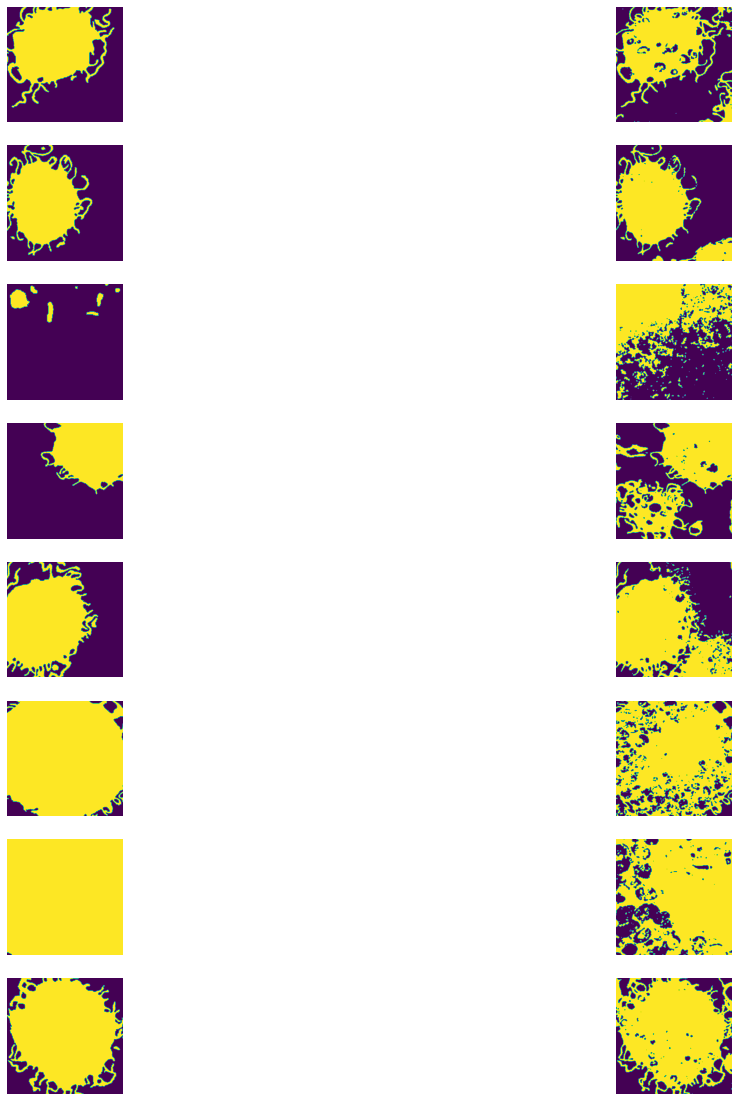

In [32]:
fig, axes = plt.subplots(testset.__len__(), 2, figsize = (20, 20))

for i in range(testset.__len__()):
  axes[i, 0].imshow(output_labels[i])
  axes[i, 0].axis('off')
  axes[i, 1].imshow(output_masks[i])
  axes[i, 1].axis('off')

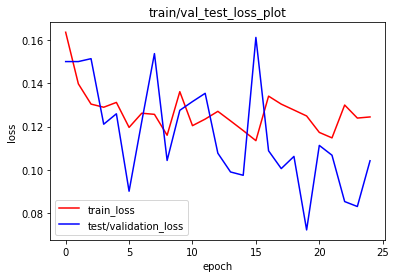

In [33]:
fig_l, axes_l = plt.subplots()
epoch_list = list(range(epoch_n))
test_loss_rec[0] = 0.15
test_loss_rec[1] = 0.15
axes_l.plot(epoch_list, train_loss_rec, label='train_loss', color='r')
axes_l.plot(epoch_list, test_loss_rec, label='test/validation_loss', color='b')
axes_l.set_xlabel('epoch')
axes_l.set_ylabel('loss')
axes_l.set_title('train/val_test_loss_plot')
axes_l.legend()
fig_l.show()